## import

In [120]:
seed = 42

import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

import random
random.seed(seed)
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.metrics import accuracy_score, f1_score, roc_curve, roc_auc_score, precision_recall_curve, auc, confusion_matrix
from imblearn.over_sampling import SMOTE

from sklearn.feature_selection import mutual_info_classif, SelectKBest, SelectPercentile, f_classif, f_regression, SelectFromModel
from scipy.spatial.distance import pdist, squareform
from scipy.stats import ttest_ind
from xgboost import XGBClassifier
import statistics

sc = StandardScaler()
import pickle

## caricamento dati

### caricamento labels pazienti

In [155]:

file_path = "../CSV/data_rad_clin_DEF.csv"

data = pd.read_csv(file_path)
labels_column = data['label']
labels = labels_column.astype(int).tolist()

labels=np.array(labels)

# Estrazione dei numeri dai nomi dei pazienti
loaded_patients = data['IDs_new'].str.extract(r'(\d+)').astype(int).squeeze().tolist()

print("Labels:", labels)
print("Number of labels:", len(labels))
print("Patient Names: ", loaded_patients )




Labels: [0 1 1 0 0 0 0 0 1 0 0 1 1 0 0 1 1 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 1 0 1 0
 0 0 1 1 0 0 1 0 1 1 1 1 1 0 0 0 1 0 0 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0 1 0 0
 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 1 0 0 1 0 0 0 0
 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1]
Number of labels: 129
Patient Names:  [5, 12, 15, 16, 17, 19, 22, 23, 24, 25, 26, 27, 29, 30, 31, 33, 35, 36, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 50, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 64, 65, 68, 69, 70, 71, 74, 75, 76, 78, 79, 81, 82, 84, 85, 86, 87, 88, 89, 90, 91, 92, 94, 95, 96, 98, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 123, 124, 126, 127, 128, 129, 133, 135, 136, 137, 138, 139, 141, 142, 144, 146, 147, 149, 150, 153, 155, 158, 159, 161, 163, 166, 168, 169, 170, 171, 175, 176, 178, 182, 183, 188, 189, 190, 193, 197, 199, 200, 205]


### caricamento features radiomica

In [122]:

file_path="../CSV/Radiomica_3D.csv"
df = pd.read_csv(file_path, sep=';')
df = df.astype(float)

# Colonne da rimuovere SOLO PER RADIOMICA
columns_to_remove = [
    'diagnostics_Image-original_Mean',
    'diagnostics_Image-original_Minimum',
    'diagnostics_Image-original_Maximum',
    'diagnostics_Mask-original_VoxelNum',
    'diagnostics_Mask-original_VolumeNum',
]

df_cleaned = df.drop(columns=columns_to_remove)
df_features = df_cleaned.drop(columns=['Paziente'])

features = df_features.to_numpy()

print(features)
print(features.shape)  


[[6.42638351e-01 4.34811323e-01 1.16096656e+01 ... 2.69972505e+03
  2.80963106e-02 1.00514866e+01]
 [6.29082835e-01 5.34401455e-01 1.06699125e+01 ... 5.06730171e+03
  4.13964322e-02 9.21642811e+00]
 [5.33839928e-01 4.15372150e-01 1.11671922e+01 ... 3.95715175e+03
  1.13273940e-02 2.75076797e+01]
 ...
 [4.66390756e-01 3.69394607e-01 1.32282545e+01 ... 1.36263582e+02
  6.99679621e-02 4.97074683e-01]
 [4.14375204e-01 3.85297007e-01 1.19250944e+01 ... 8.96173941e+03
  5.69615647e-02 1.52012405e+01]
 [4.85039433e-01 3.32916705e-01 9.71060636e+00 ... 4.02397749e+03
  7.17804108e-02 4.97083572e+00]]
(129, 107)


## funzioni varie 

In [123]:

## Rimozione feature correlation
def remove_highly_correlated_features(X, threshold=0.85):
    corr_matrix = np.corrcoef(X, rowvar=False)
    upper_triangle = np.triu(corr_matrix, k=1)
    to_drop = [column for column in range(upper_triangle.shape[0]) if any(abs(upper_triangle[column, :]) > threshold)]
    X_reduced = np.delete(X, to_drop, axis=1)
    return X_reduced, to_drop

## Rimozione features p_value
def remove_high_pvalue_features(X, y, alpha=0.05):
    selector = SelectKBest(score_func=f_classif, k='all')
    selector.fit(X, y)
    p_values = selector.pvalues_
    features_to_keep = np.where(p_values < alpha)[0]
    X_reduced = X[:, features_to_keep]
    return X_reduced, features_to_keep

## FEATURE SELECTION LASSO
def select_features_with_lasso(X, y, alpha=0.001):
    
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    coefficients = lasso.coef_
    selected_features = np.where(coefficients != 0)[0]
    X_selected = X[:, selected_features]

    return X_selected, selected_features

## FEATURE SELECTION LOGISTIC
def logistic_regression_feature_selection(X, y, num_features):
    lr = LogisticRegression(max_iter=1000, random_state=42)
    lr.fit(X, y)
    coef_abs = np.abs(lr.coef_)
    feature_importances = np.mean(coef_abs, axis=0)
    selected_features = feature_importances.argsort()[-num_features:][::-1]
    X_selected = X[:, selected_features]
    return X_selected, selected_features

## FEATURE SELECTION MRMR
def mrmr_feature_selection(X, y, num_features):
    mi = mutual_info_classif(X, y, random_state=42)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    distances = squareform(pdist(X_scaled.T, 'euclidean'))
    
    selected_features = []
    selected_indices = []

    first_feature_index = np.argmax(mi)
    selected_features.append(first_feature_index)
    selected_indices.append(first_feature_index)
    
    for _ in range(num_features - 1):
        max_relevance = -np.inf
        selected_feature_index = -1
        
        for i in range(X.shape[1]):
            if i in selected_indices:
                continue
            
            relevance = mi[i]
            redundancy = np.mean(distances[i, selected_indices])
            
            mrmr_score = relevance - redundancy
            
            if mrmr_score > max_relevance:
                max_relevance = mrmr_score
                selected_feature_index = i
        
        selected_features.append(selected_feature_index)
        selected_indices.append(selected_feature_index)

    X_selected = X[:, selected_indices]
    return X_selected, selected_indices

## FEATURE SELECTION RANDOM FOREST
def rf_feature_selection(X, y, num_features):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)
    feature_importances = rf.feature_importances_
    selected_features = np.argsort(feature_importances)[-num_features:][::-1]
    X_selected = X[:, selected_features]
    return X_selected, selected_features


## FEATURE SELECTION P_VALUE
# Seleziona e ordina le feature basate sui p-value con un test t di Student poi 
# ordina le feature in base al p-value in ordine crescente e seleziona le prime `num_features` caratteristiche.

def select_features_by_p_value(x_train_expanded, y_train_expanded, num_features):
    p_values = []
    num_features_total = x_train_expanded.shape[1]

    # Calcolo dei p-value per ciascuna feature
    for i in range(num_features_total):
        feature = x_train_expanded[:, i]
        group_0 = feature[y_train_expanded == 0]
        group_1 = feature[y_train_expanded == 1]
        t_stat, p_val = ttest_ind(group_0, group_1, equal_var=False)
        p_values.append(p_val)


    p_values = np.array(p_values)

    # Ordinare tutte le caratteristiche in base ai p-value (dal più piccolo al più grande)
    sorted_indices = np.argsort(p_values)
    sorted_indices = sorted_indices[:num_features]

    x_train_selected = x_train_expanded[:, sorted_indices]

    return x_train_selected, sorted_indices



## FUNZIONE PER RIMUOVERE FEATURES SELEZIONATE
def filter_patients_features(filtered_patients, selected_features):
    filtered_patients_selected = []

    for patient_features in filtered_patients:
        # Select only the features specified in selected_features
        patient_features_selected = patient_features[:, selected_features]
        filtered_patients_selected.append(patient_features_selected)

    return filtered_patients_selected


## funzioni di classificazione

In [252]:
## classificazione completa che ritorna la threshold migliore per la classificazione
def classification_method(selector, classifier, alpha, x_train_expanded, y_train_expanded, x_test, y_test, num_features, mode="Val", selected_features=[0], thresholds=np.arange(0.4, 0.6, 0.01)):
    best_f1_score = 0
    best_case = None

    if mode == "Val":
        selected_features = None 

        if num_features != len(x_train_expanded[0]) or alpha != 0:
            if selector == "lasso":
                X_selected, selected_features = select_features_with_lasso(x_train_expanded, y_train_expanded, alpha)
                if(len(selected_features)==0):
                    return 0
            elif selector == "logistic":
                X_selected, selected_features = logistic_regression_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "mrmr":
                X_selected, selected_features = mrmr_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "rf":
                X_selected, selected_features = rf_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "p_value":
                X_selected, selected_features = select_features_by_p_value(x_train_expanded,y_train_expanded, num_features=num_features)
            else:
                print("Wrong selector. Choose between: mrmr, rf, logistic, p_value, lasso")
                return

            x_test = x_test[:, selected_features]  # selezione delle feature anche su x_test
        else:
            X_selected = x_train_expanded
            selected_features = list(range(len(x_train_expanded[0])))  # Selezioniamo tutte le feature se non si fa feature selection

        number_features = len(selected_features)  # Numero di feature selezionate

        # Training del classificatore
        classifier.fit(X_selected, y_train_expanded)


    if (mode == "Test"): ## non addestra il classificatore e non fa feature selection
        x_test = x_test[:, selected_features]
        number_features = len(selected_features)
    

    y_proba_test = classifier.predict_proba(x_test)[:, 1]

    if(isinstance(thresholds, np.ndarray)== False): ## se la threshold viene data fissa
        thresholds=[thresholds]
        
    
    for threshold in thresholds:

            y_pred_custom_test = (y_proba_test >= threshold).astype(int)

            accuracy = accuracy_score(y_test, y_pred_custom_test)
            f1 = f1_score(y_test, y_pred_custom_test)
            roc_auc = roc_auc_score(y_test, y_proba_test)

            precision, recall, _ = precision_recall_curve(y_test, y_proba_test)
            pr_auc = auc(recall, precision)

            conf = confusion_matrix(y_test, y_pred_custom_test)

            # Se il nuovo risultato è migliore rispetto al migliore attuale (in base all'f1 e altrimenti pr_auc)
            if f1 > best_f1_score or (f1 == best_f1_score and pr_auc > (best_case['pr_auc'] if best_case else 0)):
                best_f1_score = f1
                best_case = {
                    'alpha': alpha,
                    'num_features': number_features,
                    'selected_features': selected_features,
                    'pr_auc': pr_auc,
                    'roc_auc': roc_auc,
                    'f1': f1,
                    'accuracy': accuracy,
                    'confusion_matrix': conf,
                    'best_threshold': threshold
                }

    return best_case


#####################################################################################################################################

### questo ritorna le il vettore di probabilità senza fare la classificazione
def classification_method_withoutThreshold(selector, classifier, alpha, x_train_expanded, y_train_expanded, x_test, y_test, num_features, mode="Val", selected_features=[0]):

    if mode == "Val":
        selected_features = None 

        if num_features != len(x_train_expanded[0]) or alpha != 0:
            if selector == "lasso":
                X_selected, selected_features = select_features_with_lasso(x_train_expanded, y_train_expanded, alpha)
                if (len(selected_features)==0):
                    return [0],0,[0]
            elif selector == "logistic":
                X_selected, selected_features = logistic_regression_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "mrmr":
                X_selected, selected_features = mrmr_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "rf":
                X_selected, selected_features = rf_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "p_value":
                X_selected, selected_features = select_features_by_p_value(x_train_expanded,y_train_expanded, num_features=num_features)
            else:
                print("Wrong selector. Choose between: mrmr, rf, logistic, p_value, lasso")
                return

            x_test = x_test[:, selected_features]  # selezione delle feature anche su x_test
        else:
            X_selected = x_train_expanded
            selected_features = list(range(len(x_train_expanded[0])))  # Selezioniamo tutte le feature se non si fa feature selection

        number_features = len(selected_features)  # Numero di feature selezionate

        # Training del classificatore
        classifier.fit(X_selected, y_train_expanded)


    if (mode == "Test"): ## non addestra il classificatore e non fa feature selection
        x_test = x_test[:, selected_features]
        number_features = len(selected_features)
    

    y_proba_test = classifier.predict_proba(x_test)[:, 1]

 
    return y_proba_test, number_features, selected_features


#####################################################################################################################################


### classificazione effettuata con una threshold specifica
def classification_threshold(y_proba_test,y_test, threshold, alpha, number_features, selected_features):
        
            best_case = None

            y_pred_custom_test = (y_proba_test >= threshold).astype(int)
            accuracy = accuracy_score(y_test, y_pred_custom_test)
            f1 = f1_score(y_test, y_pred_custom_test)
            roc_auc = roc_auc_score(y_test, y_proba_test)

            precision, recall, _ = precision_recall_curve(y_test, y_proba_test)
            pr_auc = auc(recall, precision)

            conf = confusion_matrix(y_test, y_pred_custom_test)
            best_case = {
                    'alpha': alpha,
                    'num_features': number_features,
                    'selected_features': selected_features,
                    'pr_auc': pr_auc,
                    'roc_auc': roc_auc,
                    'f1': f1,
                    'accuracy': accuracy,
                    'confusion_matrix': conf,
                    'threshold': threshold
                }
                
            if not best_case:
                 print("Attenzione caso vuoto") 
            return best_case

#####################################################################################################################################


# metodo che definisce la threshold ottimale attraverso Youden's J statistic (threshold_selection= 'y')
# oppure attraverso la distanza euclidea dalla curva ROC (threshold_selection= 'd')
def classification_method_selection(selector, classifier, alpha, x_train_expanded, y_train_expanded, x_test, y_test, num_features, threshold_selection, mode="Val", selected_features=[0]):
    best_case = None

    if mode == "Val":
        selected_features = None 

        if num_features != len(x_train_expanded[0]) or alpha != 0:
            if selector == "lasso":
                X_selected, selected_features = select_features_with_lasso(x_train_expanded, y_train_expanded, alpha)
                if(len(selected_features)==0):
                    return 0
            elif selector == "logistic":
                X_selected, selected_features = logistic_regression_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "mrmr":
                X_selected, selected_features = mrmr_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "rf":
                X_selected, selected_features = rf_feature_selection(x_train_expanded, y_train_expanded, num_features)
            elif selector == "p_value":
                X_selected, selected_features = select_features_by_p_value(x_train_expanded,y_train_expanded, num_features=num_features)
            else:
                print("Wrong selector. Choose between: mrmr, rf, logistic, p_value, lasso")
                return

            x_test = x_test[:, selected_features]  # selezione delle feature anche su x_test
        else:
            X_selected = x_train_expanded
            selected_features = list(range(len(x_train_expanded[0])))  # Selezioniamo tutte le feature se non si fa feature selection

        number_features = len(selected_features)  # Numero di feature selezionate

        # Training del classificatore
        classifier.fit(X_selected, y_train_expanded)


    if (mode == "Test"): ## non addestra il classificatore e non fa feature selection
        x_test = x_test[:, selected_features]
        number_features = len(selected_features)
    

    y_proba_test = classifier.predict_proba(x_test)[:, 1]

    roc_auc = roc_auc_score(y_test, y_proba_test)
    precision, recall, _ = precision_recall_curve(y_test, y_proba_test)
    pr_auc = auc(recall, precision)
        
    fpr,tpr,threshold=roc_curve(y_test,y_proba_test,pos_label=1)
    youden_j = tpr - fpr
    optimal_threshold = threshold[np.argmax(youden_j)]

    ## due modalità 
    if threshold_selection == 'y':
        youden_j = tpr - fpr
        optimal_threshold = threshold[np.argmax(youden_j)]
    elif threshold_selection == 'd':
        distances = np.sqrt((1 - tpr) ** 2 + fpr ** 2)
        optimal_threshold = threshold[np.argmin(distances)]
    else:
        print('Threshold non valida!')
        return None

    
    y_pred_custom_test = (y_proba_test >= optimal_threshold).astype(int)

    accuracy = accuracy_score(y_test, y_pred_custom_test)
    f1 = f1_score(y_test, y_pred_custom_test)
    conf = confusion_matrix(y_test, y_pred_custom_test)


    best_case = {
        'alpha': alpha,
        'num_features': number_features,
        'selected_features': selected_features,
        'pr_auc': pr_auc,
        'roc_auc': roc_auc,
        'f1': f1,
        'accuracy': accuracy,
        'confusion_matrix': conf,
        'best_threshold': optimal_threshold,
        'threshold_mode': threshold_selection
    }

    return best_case


## split

In [246]:
Y_train, y_test, X_train, X_test= train_test_split(labels, features, test_size=0.2, shuffle=False, random_state=1)

## correlation e p_value

In [247]:

## FEATURE CORRELATION

X_train_reduced, dropped_features = remove_highly_correlated_features(X_train, 0.8)
#X_val_reduced = np.delete(X_val, dropped_features, axis=1)
X_test_reduced = np.delete(X_test, dropped_features, axis=1)

#print(X_train_reduced.shape)
#print(X_test_reduced.shape)
#print(X_val_reduced.shape)

# RIMOZIONE FEATURES CON P_VALUE ELEVATO

#X_train_reduced, features_to_keep = remove_high_pvalue_features(X_train, Y_train, alpha=0.05)
#X_val_reduced = X_val_reduced[:, features_to_keep]
#X_test_reduced = X_test[:, features_to_keep]


print(X_train_reduced.shape)
print(X_test_reduced.shape)
#print(X_val_reduced.shape)

(103, 482)
(26, 482)


## parametri

In [248]:


alpha_1 = np.linspace(0, 10, 21).tolist() ## questo è il range per la radiomica - con vgg a 2.5 non ne trova piu nessuna

alpha_2 = np.linspace(0, 0.005, 21).tolist()

alpha_values=alpha_2 + alpha_1 
alpha_values.remove(0.0)


thresholds=np.arange(0.4, 0.61, 0.01) 


selectors=['lasso','p_value', 'mrmr','rf', 'logistic']

classifiers=['XgBoost',  'SVM', 'ensemble','RandomForest', 'Logistic', 'MLP']


# METODO 2 - threshold tuning con val
Attraverso gridsearch sui risultati delle performance medie ottenute dalla cross validation trova la migliore combinazione tra classifier, selector, num_features (o alpha) e threshold. poi applica questa configurazione al test
scelgo la configurazione migliore attraverso f1

## Loop per Validation

In [249]:
n_folds=5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)


template_dict = {
                'fold': None,
                'classifier': None,
                'selector': None,
                'alpha': None,
                'num_features': None,
                'pr_auc': None,
                'roc_auc': None,
                'f1': None,
                'accuracy': None,
                'confusion_matrix': [],
                'threshold': None,
                'selected_features': [],
            }

## creazione di dizionari vuoti (range con numero elevato casuale)
results_val_2_others = [template_dict.copy() for _ in range(300000)]
results_val_2_others.append(template_dict.copy())

results_val_2_lasso = [template_dict.copy() for _ in range(300000)]
results_val_2_lasso.append(template_dict.copy())

smote = SMOTE()

k=0
old_count = 0
for fold_idx, (train_index, val_index) in enumerate(skf.split(X_train_reduced, Y_train)):
    print("Starting with fold:", fold_idx)

    x_train_red, X_val_reduced = X_train_reduced[train_index], X_train_reduced[val_index]
    y_train_red, y_val = Y_train[train_index], Y_train[val_index]

    x_train_reduced, y_train = smote.fit_resample(x_train_red, y_train_red)

    zero_count = np.sum(y_val == 0)
    one_count = np.sum(y_val == 1)

    #print(f"Numero di 0 nel train: {zero_count}")
    #print(f"Numero di 1 nel train: {one_count}")

    for i, classifier in enumerate(classifiers):
        print("Starting with classifier:", classifier)
        for j, selector in enumerate(selectors):
            #print("Starting with selector:", selector)

            if(selector=='lasso'):
                selected_features_temp= []

                for alpha in alpha_values:
                    #print("alpha: ", alpha)
                    if classifier == 'RandomForest':
                        classi = RandomForestClassifier(n_estimators=100, random_state=42)
                    elif classifier == 'Logistic':
                        classi = LogisticRegression(random_state=42)
                    elif classifier == 'SVM':
                        classi = SVC(kernel='rbf', probability=True, random_state=42)
                    elif classifier == 'XgBoost':
                        classi = XGBClassifier(random_state=42)
                    elif classifier == 'MLP':
                        classi = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive')
                    elif classifier == 'ensemble':
                        rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
                        logistic_model = LogisticRegression(random_state=42)
                        svc_model = SVC(kernel='rbf', probability=True, random_state=42)
                        classi = VotingClassifier(
                            estimators=[
                                ('random_forest', rf_model),
                                ('logistic', logistic_model),
                                ('svc', svc_model)
                            ],
                            voting='soft'
                            )

                    y_proba_test, number_features, selected_features = classification_method_withoutThreshold(selector, classi, alpha, x_train_reduced, y_train, X_val_reduced, y_val, num_features=0, mode="Val", selected_features=[0])
                    
                    if (np.array_equal(y_proba_test,[0]) and  number_features==0 and np.array_equal(selected_features,[0])):
                        continue

                    #found=False
                    #for vec in selected_features_temp:
                    #   if np.array_equal(selected_features, vec):
                    #       found=True
                    #if found==True:
                    #   continue

                    fpr_val, tpr_val, roc_thresholds_val = roc_curve(y_val, y_proba_test)

                    # Calcola il ROC AUC
                    roc_auc_val = roc_auc_score(y_val, y_proba_test)
                    precision, recall, _ = precision_recall_curve(y_val, y_proba_test)
                    pr_auc = auc(recall, precision)

                    best_case_val = None

                    # Itera su tutte le soglie e salva i risultati per ognuna
                    for threshold in thresholds:
                        best_case_val = classification_threshold(y_proba_test, y_val, threshold, alpha, number_features, selected_features)
                        
                        if best_case_val:
                            results_val_2_lasso[k] = {
                                        'fold': fold_idx,
                                        'classifier': classifier,
                                        'selector': selector,
                                        'alpha': alpha,
                                        'num_features': number_features,
                                        'selected_features': best_case_val['selected_features'],
                                        'pr_auc': pr_auc,
                                        'roc_auc': roc_auc_val,
                                        'f1': best_case_val['f1'],
                                        'accuracy': best_case_val['accuracy'],
                                        'confusion_matrix': best_case_val['confusion_matrix'],
                                        'threshold': threshold,
                                        'fpr': fpr_val,
                                        'tpr': tpr_val, 
                                        'roc_thresholds_val':roc_thresholds_val, 
                                        'model': classi
                                    }
    

                            k = k + 1

            else:

                limit=len(x_train_reduced[0]) + 1
                limit=20
                for t in range(1, limit):
                        #print("Number of features ", t)

                        if classifier == 'RandomForest':
                            classi = RandomForestClassifier(n_estimators=100, random_state=42)
                        elif classifier == 'Logistic':
                            classi = LogisticRegression(random_state=42)
                        elif classifier == 'SVM':
                            classi = SVC(kernel='rbf', probability=True, random_state=42)
                        elif classifier == 'XgBoost':
                            classi = XGBClassifier(random_state=42)
                        elif classifier == 'MLP':
                            classi = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive', activation='logistic')
                        elif classifier == 'ensemble':
                            rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
                            logistic_model = LogisticRegression(random_state=42)
                            svc_model = SVC(kernel='rbf', probability=True, random_state=42)
                            classi = VotingClassifier(
                                estimators=[
                                    ('random_forest', rf_model),
                                    ('logistic', logistic_model),
                                    ('svc', svc_model)
                                ],
                                voting='soft'
                                )

                    
                        y_proba_test, number_features, selected_features = classification_method_withoutThreshold(selector, classi, 0, x_train_reduced, y_train, X_val_reduced, y_val, num_features=t, mode="Val", selected_features=[0])

                        fpr_val, tpr_val, roc_thresholds_val = roc_curve(y_val, y_proba_test)
    
                        # Calcola il ROC AUC
                        roc_auc_val = roc_auc_score(y_val, y_proba_test)
                        precision, recall, _ = precision_recall_curve(y_val, y_proba_test)
                        pr_auc = auc(recall, precision)

                        # Variabili per tenere traccia del miglior F1 score e threshold sul validation
                        best_f1_val = -1
                        best_threshold_val = 0
                        best_case_val = None
                        
                        # Itera su tutte le soglie e salva i risultati per ognuna
                        for threshold in thresholds:
            
                            best_case_val = classification_threshold(y_proba_test, y_val, threshold, 0, t, selected_features)
                                
                            if best_case_val:
                                results_val_2_others[k] = {
                                    'fold': fold_idx,
                                    'classifier': classifier,
                                    'selector': selector,
                                    'alpha': 0,
                                    'num_features': t,
                                    'selected_features': best_case_val['selected_features'],
                                    'pr_auc': pr_auc,
                                    'roc_auc': roc_auc_val,
                                    'f1': best_case_val['f1'],
                                    'accuracy': best_case_val['accuracy'],
                                    'confusion_matrix': best_case_val['confusion_matrix'],
                                    'threshold': threshold,
                                    'fpr': fpr_val,
                                    'tpr': tpr_val, 
                                    'roc_thresholds_val':roc_thresholds_val,
                                    'model': classi 
                                }
                                k = k + 1
                            else:
                                print("sono vuoto")

Starting with fold: 0
Numero di 0 nel train: 12
Numero di 1 nel train: 9
Starting with classifier: XgBoost
Starting with selector: lasso
Starting with selector: p_value
Starting with selector: mrmr
Starting with selector: rf
Starting with selector: logistic
Starting with classifier: SVM
Starting with selector: lasso
Starting with selector: p_value
Starting with selector: mrmr
Starting with selector: rf
Starting with selector: logistic
Starting with classifier: ensemble
Starting with selector: lasso
Starting with selector: p_value
Starting with selector: mrmr
Starting with selector: rf
Starting with selector: logistic
Starting with classifier: RandomForest
Starting with selector: lasso
Starting with selector: p_value
Starting with selector: mrmr
Starting with selector: rf
Starting with selector: logistic
Starting with classifier: Logistic
Starting with selector: lasso
Starting with selector: p_value
Starting with selector: mrmr
Starting with selector: rf
Starting with selector: logistic

## Sorting the results
gridsearch per classificatore, selector, num_features (alpha) e threshold
ordinati per f1 e se parità threshold auc

In [250]:
num_features_range = list(range(1, (len(x_train_reduced[0]) + 1)))
num_features_range=list(range(1,20))

grid_results_others = {}
grid_results_lasso = {}

selectors = ['mrmr', 'rf', 'logistic', 'p_value']

# Itera su tutte le combinazioni di parametri (classifier, selector, num_features, threshold)
for classifier in classifiers:
    print(f"Sto iniziando classifier {classifier}")
    for selector in selectors:
            #print(f"Sto iniziando selector {selector}")
            for num_features in num_features_range:
                for threshold in thresholds:
                    # Filtra i risultati che corrispondono a questa combinazione di parametri
                    filtered_results=[]
                    for res in results_val_2_others:
                        ## qui filtro per num_features
                        if (res['classifier'] == classifier and res['selector'] == selector and res['num_features'] == num_features and res['threshold'] == threshold):
                            filtered_results.append(res)
                
                    if filtered_results:
                        pr_auc_values = [res['pr_auc'] for res in filtered_results]
                        f1_values = [res['f1'] for res in filtered_results]
                        accuracy_values = [res['accuracy'] for res in filtered_results]

                        # Calcola le medie delle metriche
                        avg_pr_auc = sum(pr_auc_values) / len(pr_auc_values)
                        avg_f1 = sum(f1_values) / len(f1_values)
                        avg_accuracy = sum(accuracy_values) / len(accuracy_values)

                        # Calcola la deviazione standard delle metriche
                        std_pr_auc = statistics.stdev(pr_auc_values) if len(pr_auc_values) > 1 else 0
                        std_f1 = statistics.stdev(f1_values) if len(f1_values) > 1 else 0
                        std_accuracy = statistics.stdev(accuracy_values) if len(accuracy_values) > 1 else 0

                        # Memorizza i risultati medi e la deviazione standard di questa combinazione
                        grid_results_others[(classifier, selector, num_features, threshold)] = {
                            'avg_pr_auc': avg_pr_auc,
                            'std_pr_auc': std_pr_auc,
                            'avg_f1': avg_f1,
                            'std_f1': std_f1,
                            'avg_accuracy': avg_accuracy,
                            'std_accuracy': std_accuracy
                        }





## ORA PER LASSO
selectors = ['lasso']
for classifier in classifiers:
    print(f"Sto iniziando classifier {classifier}")
    for selector in selectors:
        print(f"Sto iniziando selector {selector}")
        for alpha in alpha_values:
            for threshold in thresholds:
                filtered_results = []
                for res in results_val_2_lasso:
                    ## qui filtro per alpha
                    if (res['classifier'] == classifier and res['selector'] == selector and res['alpha'] == alpha and res['threshold'] == threshold):
                        filtered_results.append(res)

                if filtered_results:
                    pr_auc_values = [res['pr_auc'] for res in filtered_results]
                    f1_values = [res['f1'] for res in filtered_results]
                    accuracy_values = [res['accuracy'] for res in filtered_results]

        
                    avg_pr_auc = sum(pr_auc_values) / len(pr_auc_values)
                    avg_f1 = sum(f1_values) / len(f1_values)
                    avg_accuracy = sum(accuracy_values) / len(accuracy_values)

         
                    std_pr_auc = statistics.stdev(pr_auc_values) if len(pr_auc_values) > 1 else 0
                    std_f1 = statistics.stdev(f1_values) if len(f1_values) > 1 else 0
                    std_accuracy = statistics.stdev(accuracy_values) if len(accuracy_values) > 1 else 0

                    grid_results_lasso[(classifier, selector, alpha, threshold)] = {
                        'avg_pr_auc': avg_pr_auc,
                        'std_pr_auc': std_pr_auc,
                        'avg_f1': avg_f1,
                        'std_f1': std_f1,
                        'avg_accuracy': avg_accuracy,
                        'std_accuracy': std_accuracy
                    }

# Ordina le combinazioni per 'avg_f1', e in caso di parità, per 'avg_pr_auc'
sorted_results_others = sorted(grid_results_others.items(), key=lambda x: (x[1]['avg_f1'], x[1]['avg_pr_auc']),reverse=True)
sorted_results_lasso = sorted(grid_results_lasso.items(), key=lambda x: (x[1]['avg_f1'], x[1]['avg_pr_auc']), reverse=True)

# Combina i risultati di entrambi i grid search
sorted_results_2 = sorted_results_others + sorted_results_lasso
sorted_results_2 = sorted(sorted_results_2, key=lambda x: (x[1]['avg_f1'], x[1]['avg_pr_auc']), reverse=True)



Sto iniziando classifier XgBoost
Sto iniziando classifier SVM
Sto iniziando classifier ensemble
Sto iniziando classifier RandomForest
Sto iniziando classifier Logistic
Sto iniziando classifier MLP
Sto iniziando classifier XgBoost
Sto iniziando selector lasso
Sto iniziando classifier SVM
Sto iniziando selector lasso
Sto iniziando classifier ensemble
Sto iniziando selector lasso
Sto iniziando classifier RandomForest
Sto iniziando selector lasso
Sto iniziando classifier Logistic
Sto iniziando selector lasso
Sto iniziando classifier MLP
Sto iniziando selector lasso


## applico al test le migliori n configurazioni trovate

In [255]:
n=30
best_combinations = sorted_results_2[:n] ## mostrando le n migliori configurazioni

print(f"Migliori {n} combinazioni di parametri:")
for i, (params, metrics) in enumerate(best_combinations, start=1):

    print(f"\n#{i}:")
    print(f"Classifier: {params[0]}")
    print(f"Selector: {params[1]}")
    if (params[1]=='lasso'):
        print(f"Alpha: {params[2]}")
    else:
        print(f"Num_features: {params[2]}")
    print(f"Threshold: {params[3]}")

    print(f"Performance medie sul val set: \nF1 = {metrics['avg_f1']} (std = {metrics['std_f1']}), "f"PR AUC = {metrics['avg_pr_auc']} (std = {metrics['std_pr_auc']}), "f"Accuracy = {metrics['avg_accuracy']} (std = {metrics['std_accuracy']})")



    if params[0] == 'RandomForest':
                            classi = RandomForestClassifier(n_estimators=100, random_state=42)
    elif params[0] == 'Logistic':
                            classi = LogisticRegression(random_state=42)
    elif params[0] == 'SVM':
                            classi = SVC(kernel='rbf', probability=True, random_state=42)
    elif params[0] == 'XgBoost':
                            classi = XGBClassifier(random_state=42)
    elif params[0] == 'MLP':
                            classi = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive')
    elif params[0] == 'ensemble':
                            rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
                            logistic_model = LogisticRegression(random_state=42)
                            svc_model = SVC(kernel='rbf', probability=True, random_state=42)
                            classi = VotingClassifier(
                                estimators=[
                                    ('random_forest', rf_model),
                                    ('logistic', logistic_model),
                                    ('svc', svc_model)],
                                voting='soft')

   
    if(params[1]=='lasso'):     
        best_case=classification_method(params[1], classi, params[2], X_train_reduced, Y_train, X_test_reduced, y_test, 0, mode="Val", selected_features=[0], thresholds=params[3])
    else: 
        best_case=classification_method(params[1], classi, 0, X_train_reduced, Y_train, X_test_reduced, y_test, params[2], mode="Val", selected_features=[0], thresholds=params[3])

    print("Metrics on the TEST set:")
        
    if(best_case==0):
            print("found 0 features")
            continue
    if (params[1]=='lasso'):
                    print(f"Alpha: {best_case['alpha']}")
    print(f"Number of Features: {best_case['num_features']}")
    print(f"Threshold: {best_case['best_threshold']}")
    print(f"Selected Features: {best_case['selected_features']}")
    print(f"Precision-Recall AUC: {best_case['pr_auc']}")
    print(f"ROC AUC: {best_case['roc_auc']}")
    print(f"F1 Score: {best_case['f1']}")
    print(f"Accuracy: {best_case['accuracy']}")
    print(f"Confusion Matrix: \n{np.array(best_case['confusion_matrix'])}")


Migliori 30 combinazioni di parametri:

#1:
Classifier: MLP
Selector: lasso
Alpha: 5.5
Threshold: 0.4600000000000001
Performance medie sul val set: 
F1 = 0.7368421052631579 (std = 0), PR AUC = 0.484451051375716 (std = 0), Accuracy = 0.7619047619047619 (std = 0)
Metrics on the TEST set:
found 0 features

#2:
Classifier: MLP
Selector: lasso
Alpha: 5.0
Threshold: 0.4
Performance medie sul val set: 
F1 = 0.7055555555555556 (std = 0.041943524640393075), PR AUC = 0.6898332239878507 (std = 0.1811900238957395), Accuracy = 0.6912698412698411 (std = 0.13128385176955212)
Metrics on the TEST set:
found 0 features

#3:
Classifier: MLP
Selector: lasso
Alpha: 5.0
Threshold: 0.41000000000000003
Performance medie sul val set: 
F1 = 0.7055555555555556 (std = 0.041943524640393075), PR AUC = 0.6898332239878507 (std = 0.1811900238957395), Accuracy = 0.6912698412698411 (std = 0.13128385176955212)
Metrics on the TEST set:
found 0 features

#4:
Classifier: ensemble
Selector: logistic
Num_features: 1
Threshold

# METODO 1 - threshold dinamica 
Attraverso gridsearch sui risultati delle performance medie ottenute dalla cross validation trova la migliore combinazione tra classifier, selector, num_features (o alpha). scelgo la configurazione migliore in base a  roc_auc.
il test sceglie la treshold o attraverso Youden o attraverso la distanza euclidea 



## Loop per validation

In [217]:
classifiers = ['SVM', 'RandomForest', 'ensemble', 'XgBoost', 'Logistic', 'MLP']
selectors = ['mrmr', 'rf', 'logistic', 'p_value', 'lasso']

n_folds=5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)


template_dict = {
                'fold': None,
                'classifier': None,
                'selector': None,
                'alpha': None,
                'num_features': None,
                'pr_auc': None,
                'roc_auc': None,
                'f1': None,
                'accuracy': None,
                'confusion_matrix': [],
                'best_threshold': None,
                'selected_features': []
            }

## creazione di dizionari vuoti (range con numero elevato casuale)
results_val_1_others = [template_dict.copy() for _ in range(300000)]
results_val_1_others.append(template_dict.copy())

results_val_1_lasso = [template_dict.copy() for _ in range(300000)]
results_val_1_lasso.append(template_dict.copy())

smote = SMOTE()

k=0
old_count = 0
for fold_idx, (train_index, val_index) in enumerate(skf.split(X_train_reduced, Y_train)):
    print("Starting with fold:", fold_idx)

    x_train_red, X_val_reduced = X_train_reduced[train_index], X_train_reduced[val_index]
    y_train_red, y_val = Y_train[train_index], Y_train[val_index]

    x_train_reduced, y_train = smote.fit_resample(x_train_red, y_train_red)

    for i, classifier in enumerate(classifiers):
        print("Starting with classifier:", classifier)
        for j, selector in enumerate(selectors):
            #print("Starting with selector:", selector)

            if(selector=='lasso'):
                selected_features_temp= []

                for alpha in alpha_values:
                    if classifier == 'RandomForest':
                        classi = RandomForestClassifier(n_estimators=100, random_state=42)
                    elif classifier == 'Logistic':
                        classi = LogisticRegression(random_state=42)
                    elif classifier == 'SVM':
                        classi = SVC(kernel='rbf', probability=True, random_state=42)
                    elif classifier == 'XgBoost':
                        classi = XGBClassifier(random_state=42)
                    elif classifier == 'MLP':
                        classi = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive')
                    elif classifier == 'ensemble':
                        rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
                        logistic_model = LogisticRegression(random_state=42)
                        svc_model = SVC(kernel='rbf', probability=True, random_state=42)
                        classi = VotingClassifier(
                            estimators=[
                                ('random_forest', rf_model),
                                ('logistic', logistic_model),
                                ('svc', svc_model)
                            ],
                            voting='soft'
                            )

                    best_case_val= classification_method_selection(selector, classi, alpha, x_train_reduced, y_train, X_val_reduced, y_val, 0, threshold_selection='y', mode="Val", selected_features=[0])
                    if(best_case_val==0):
                         continue
                        
                    if best_case_val:
                            results_val_1_lasso[k] = {
                                        'fold': fold_idx,
                                        'classifier': classifier,
                                        'selector': selector,
                                        'alpha': alpha,
                                        'num_features': best_case_val['num_features'],
                                        'selected_features': best_case_val['selected_features'],
                                        'pr_auc': best_case_val['pr_auc'],
                                        'roc_auc': best_case_val['roc_auc'],
                                        'f1': best_case_val['f1'],
                                        'accuracy': best_case_val['accuracy'],
                                        'confusion_matrix': best_case_val['confusion_matrix'],
                                        'best_threshold': best_case_val['best_threshold'],
                                        'threshold_mode': best_case_val['threshold_mode']
                                   
                                    }
                    k = k + 1

            else:

                limit=len(x_train_reduced[0]) + 1
                limit=20
                for t in range(1, limit):
                        #print("Number of features ", t)

                        if classifier == 'RandomForest':
                            classi = RandomForestClassifier(n_estimators=100, random_state=42)
                        elif classifier == 'Logistic':
                            classi = LogisticRegression(random_state=42)
                        elif classifier == 'SVM':
                            classi = SVC(kernel='rbf', probability=True, random_state=42)
                        elif classifier == 'XgBoost':
                            classi = XGBClassifier(random_state=42)
                        elif classifier == 'MLP':
                            classi = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive', activation='logistic')
                        elif classifier == 'ensemble':
                            rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
                            logistic_model = LogisticRegression(random_state=42)
                            svc_model = SVC(kernel='rbf', probability=True, random_state=42)
                            classi = VotingClassifier(
                                estimators=[
                                    ('random_forest', rf_model),
                                    ('logistic', logistic_model),
                                    ('svc', svc_model)
                                ],
                                voting='soft'
                                )

                        best_case_val= classification_method_selection(selector, classi, 0, x_train_reduced, y_train, X_val_reduced, y_val, t, threshold_selection='y', mode="Val", selected_features=[0])
            
                        
                        if best_case_val:
                                results_val_1_lasso[k] = {
                                            'fold': fold_idx,
                                            'classifier': classifier,
                                            'selector': selector,
                                            'alpha': 0,
                                            'num_features': t,
                                            'selected_features': best_case_val['selected_features'],
                                            'pr_auc': best_case_val['pr_auc'],
                                            'roc_auc': best_case_val['roc_auc'],
                                            'f1': best_case_val['f1'],
                                            'accuracy': best_case_val['accuracy'],
                                            'confusion_matrix': best_case_val['confusion_matrix'],
                                            'best_threshold': best_case_val['best_threshold'],
                                            'threshold_mode': best_case_val['threshold_mode']
                                    
                                        }
                        k = k + 1

Starting with fold: 0
Starting with classifier: SVM
Starting with selector: mrmr
Starting with selector: rf
Starting with selector: logistic
Starting with selector: p_value
Starting with selector: lasso
Starting with classifier: RandomForest
Starting with selector: mrmr
Starting with selector: rf
Starting with selector: logistic
Starting with selector: p_value
Starting with selector: lasso
Starting with classifier: ensemble
Starting with selector: mrmr
Starting with selector: rf
Starting with selector: logistic
Starting with selector: p_value
Starting with selector: lasso
Starting with classifier: XgBoost
Starting with selector: mrmr
Starting with selector: rf
Starting with selector: logistic
Starting with selector: p_value
Starting with selector: lasso
Starting with classifier: Logistic
Starting with selector: mrmr
Starting with selector: rf
Starting with selector: logistic
Starting with selector: p_value
Starting with selector: lasso
Starting with classifier: MLP
Starting with select

## Sorting the results

In [218]:
num_features_range = list(range(1, (len(x_train_reduced[0]) + 1)))
num_features_range = list(range(1, 20))

grid_results_others = {}
grid_results_lasso = {}

selectors = ['mrmr', 'rf', 'logistic', 'p_value']

# Itera su tutte le combinazioni di parametri (classifier, selector, num_features, threshold)
for classifier in classifiers:
    print(f"Sto iniziando classifier {classifier}")
    for selector in selectors:
            #print(f"Sto iniziando selector {selector}")
            for num_features in num_features_range:
                    
                    # Filtra i risultati che corrispondono a questa combinazione di parametri
                    filtered_results=[]
                    for res in results_val_2_others:
                        ## qui filtro per num_features
                        if (res['classifier'] == classifier and res['selector'] == selector and res['num_features'] == num_features):
                            filtered_results.append(res)
                
                    if filtered_results:
                        pr_auc_values = [res['pr_auc'] for res in filtered_results]
                        f1_values = [res['f1'] for res in filtered_results]
                        accuracy_values = [res['accuracy'] for res in filtered_results]
                        roc_values=[res['roc_auc'] for res in filtered_results]

                        # Calcola le medie delle metriche
                        avg_pr_auc = sum(pr_auc_values) / len(pr_auc_values)
                        avg_f1 = sum(f1_values) / len(f1_values)
                        avg_accuracy = sum(accuracy_values) / len(accuracy_values)
                        avg_roc = sum(roc_values) / len(roc_values)

                        # Calcola la deviazione standard delle metriche
                        std_pr_auc = statistics.stdev(pr_auc_values) if len(pr_auc_values) > 1 else 0
                        std_f1 = statistics.stdev(f1_values) if len(f1_values) > 1 else 0
                        std_accuracy = statistics.stdev(accuracy_values) if len(accuracy_values) > 1 else 0
                        std_roc_auc = statistics.stdev(roc_values) if len(roc_values) > 1 else 0

                        # Memorizza i risultati medi e la deviazione standard di questa combinazione
                        grid_results_others[(classifier, selector, num_features)] = {
                            'avg_pr_auc': avg_pr_auc,
                            'std_pr_auc': std_pr_auc,
                            'avg_f1': avg_f1,
                            'std_f1': std_f1,
                            'avg_accuracy': avg_accuracy,
                            'std_accuracy': std_accuracy,
                            'avg_roc_auc': avg_roc,
                            'std_roc_auc': std_roc_auc
                        }



## ORA PER LASSO
selectors = ['lasso']
for classifier in classifiers:
    print(f"Sto iniziando classifier {classifier}")
    for selector in selectors:
        print(f"Sto iniziando selector {selector}")
        for alpha in alpha_values:
                filtered_results = []
                for res in results_val_2_lasso:
                    ## qui filtro per alpha
                    if (res['classifier'] == classifier and res['selector'] == selector and res['alpha'] == alpha):
                        filtered_results.append(res)

                if filtered_results:
                    pr_auc_values = [res['pr_auc'] for res in filtered_results]
                    f1_values = [res['f1'] for res in filtered_results]
                    accuracy_values = [res['accuracy'] for res in filtered_results]
                    roc_values=[res['roc_auc'] for res in filtered_results]

        
                    avg_pr_auc = sum(pr_auc_values) / len(pr_auc_values)
                    avg_f1 = sum(f1_values) / len(f1_values)
                    avg_accuracy = sum(accuracy_values) / len(accuracy_values)
                    avg_roc = sum(roc_values) / len(roc_values)

         
                    std_pr_auc = statistics.stdev(pr_auc_values) if len(pr_auc_values) > 1 else 0
                    std_f1 = statistics.stdev(f1_values) if len(f1_values) > 1 else 0
                    std_accuracy = statistics.stdev(accuracy_values) if len(accuracy_values) > 1 else 0
                    std_roc_auc = statistics.stdev(roc_values) if len(roc_values) > 1 else 0

                    grid_results_lasso[(classifier, selector, alpha)] = {
                        'avg_pr_auc': avg_pr_auc,
                        'std_pr_auc': std_pr_auc,
                        'avg_f1': avg_f1,
                        'std_f1': std_f1,
                        'avg_accuracy': avg_accuracy,
                        'std_accuracy': std_accuracy,
                        'avg_roc_auc': avg_roc,
                        'std_roc_auc': std_roc_auc

                    }

# Ordina le combinazioni per 'avg_f1', e in caso di parità, per 'avg_pr_auc'
sorted_results_others = sorted(grid_results_others.items(), key=lambda x: (x[1]['avg_roc_auc'], x[1]['avg_pr_auc']),reverse=True)
sorted_results_lasso = sorted(grid_results_lasso.items(), key=lambda x: (x[1]['avg_roc_auc'], x[1]['avg_pr_auc']), reverse=True)

# Combina i risultati di entrambi i grid search
sorted_results_1 = sorted_results_others + sorted_results_lasso
sorted_results_1 = sorted(sorted_results_1, key=lambda x: (x[1]['avg_roc_auc'], x[1]['avg_pr_auc']), reverse=True)



Sto iniziando classifier SVM
Sto iniziando selector mrmr
Sto iniziando selector rf
Sto iniziando selector logistic
Sto iniziando selector p_value
Sto iniziando classifier RandomForest
Sto iniziando selector mrmr
Sto iniziando selector rf
Sto iniziando selector logistic
Sto iniziando selector p_value
Sto iniziando classifier ensemble
Sto iniziando selector mrmr
Sto iniziando selector rf
Sto iniziando selector logistic
Sto iniziando selector p_value
Sto iniziando classifier XgBoost
Sto iniziando selector mrmr
Sto iniziando selector rf
Sto iniziando selector logistic
Sto iniziando selector p_value
Sto iniziando classifier Logistic
Sto iniziando selector mrmr
Sto iniziando selector rf
Sto iniziando selector logistic
Sto iniziando selector p_value
Sto iniziando classifier MLP
Sto iniziando selector mrmr
Sto iniziando selector rf
Sto iniziando selector logistic
Sto iniziando selector p_value
Sto iniziando classifier SVM
Sto iniziando selector lasso
Sto iniziando classifier RandomForest
Sto i

## applico al test le migliori n configurazioni trovate

In [231]:
n=30
best_combinations = sorted_results_1[:n] ## mostrando le n migliori configurazioni

print(f"Migliori {n} combinazioni di parametri:")
for i, (params, metrics) in enumerate(best_combinations, start=1):

    print(f"\n#{i}:")
    print(f"Classifier: {params[0]}")
    print(f"Selector: {params[1]}")
    if (params[1]=='lasso'):
        print(f"Alpha: {params[2]}")
    else:
        print(f"Num_features: {params[2]}")

    print(f"Performance medie sul val set: \nF1 = {metrics['avg_f1']} (std = {metrics['std_f1']}), "f"PR AUC = {metrics['avg_pr_auc']} (std = {metrics['std_pr_auc']}), "f"Accuracy = {metrics['avg_accuracy']} (std = {metrics['std_accuracy']}), "f"ROC AUC = {metrics['avg_roc_auc']} (std = {metrics['std_roc_auc']})")



    if params[0] == 'RandomForest':
                            classi = RandomForestClassifier(n_estimators=100, random_state=42)
    elif params[0] == 'Logistic':
                            classi = LogisticRegression(random_state=42)
    elif params[0] == 'SVM':
                            classi = SVC(kernel='rbf', probability=True, random_state=42)
    elif params[0] == 'XgBoost':
                            classi = XGBClassifier(random_state=42)
    elif params[0] == 'MLP':
                            classi = MLPClassifier(hidden_layer_sizes=(128, 64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive')
    elif params[0] == 'ensemble':
                            rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
                            logistic_model = LogisticRegression(random_state=42)
                            svc_model = SVC(kernel='rbf', probability=True, random_state=42)
                            classi = VotingClassifier(
                                estimators=[
                                    ('random_forest', rf_model),
                                    ('logistic', logistic_model),
                                    ('svc', svc_model)],
                                voting='soft')

   
    if(params[1]=='lasso'):     
                    best_case= classification_method_selection(params[1], classi, params[2], X_train_reduced, Y_train, X_test_reduced, y_test, 0, threshold_selection='y', mode="Val", selected_features=[0])
    else: 
                    best_case= classification_method_selection(params[1], classi, 0, X_train_reduced, Y_train, X_test_reduced, y_test, params[2], threshold_selection='y', mode="Val", selected_features=[0])

    #if(best_case['f1'] > 0.5):
    
    print("Metrics on the TEST set:")

    if (params[1]=='lasso'):
            print(f"Alpha: {params[2]}")
    print(f"Number of Features: {best_case['num_features']}")
    print(f"Threshold: {best_case['best_threshold']}")
    print(f"Threshold Mode: {best_case['threshold_mode']}")
    print(f"Selected Features: {best_case['selected_features']}")
    print(f"Precision-Recall AUC: {best_case['pr_auc']}")
    print(f"ROC AUC: {best_case['roc_auc']}")
    print(f"F1 Score: {best_case['f1']}")
    print(f"Accuracy: {best_case['accuracy']}")
    print(f"Confusion Matrix: \n{np.array(best_case['confusion_matrix'])}")


Migliori 30 combinazioni di parametri:

#1:
Classifier: SVM
Selector: mrmr
Num_features: 18
Performance medie sul val set: 
F1 = 0.4129131523680685 (std = 0.28162227772879606), PR AUC = 0.5946132944080238 (std = 0.1935521026752412), Accuracy = 0.5391534391534394 (std = 0.09338387975623404), ROC AUC = 0.6305246913580259 (std = 0.19052451117031663)
Metrics on the TEST set:
Number of Features: 18
Threshold: 0.44795151822638274
Threshold Mode: y
Selected Features: [208, 308, 93, 122, 83, 417, 377, 7, 47, 433, 364, 281, 163, 212, 379, 264, 137, 290]
Precision-Recall AUC: 0.3106421923836158
ROC AUC: 0.5555555555555556
F1 Score: 0.5581395348837209
Accuracy: 0.5128205128205128
Confusion Matrix: 
[[ 8 19]
 [ 0 12]]

#2:
Classifier: RandomForest
Selector: rf
Num_features: 12
Performance medie sul val set: 
F1 = 0.5325904512073578 (std = 0.0942499789497033), PR AUC = 0.6094531280039855 (std = 0.12530767224462575), Accuracy = 0.5656084656084658 (std = 0.0891092861878566), ROC AUC = 0.6045833333333

TypeError: 'int' object is not subscriptable

# PLOTS

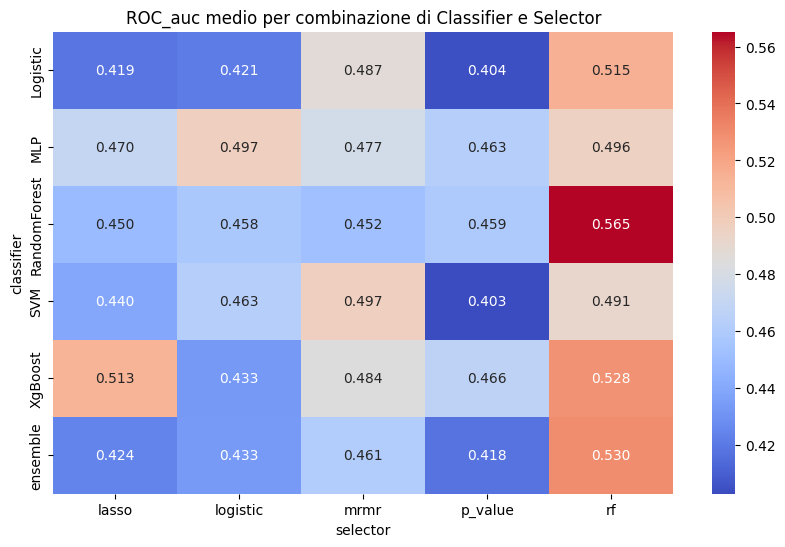

In [229]:

results_val_1=results_val_1_others+results_val_1_lasso
results_df = pd.DataFrame(results_val_1)

heatmap_data = results_df.pivot_table(index='classifier', columns='selector', values='roc_auc', aggfunc='mean')


plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".3f")
plt.title('ROC_auc medio per combinazione di Classifier e Selector')
plt.show()

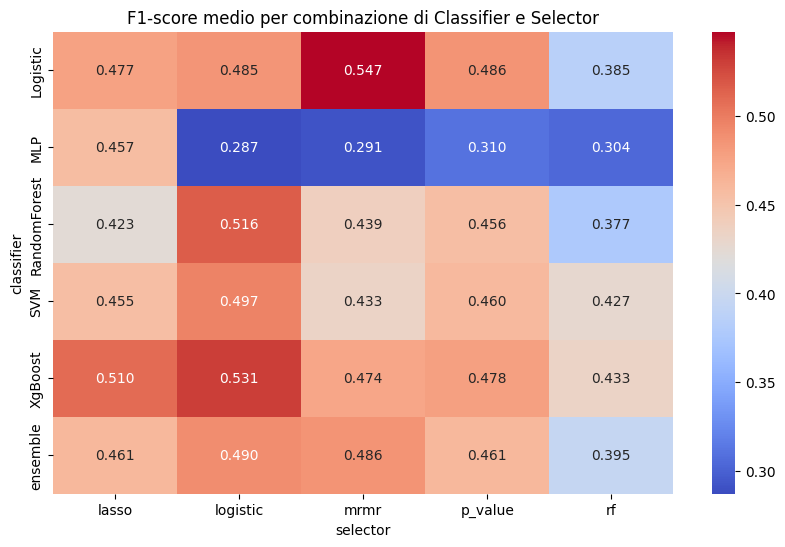

In [256]:
selectors=['lasso', 'rf', 'logistic', 'mrmr', 'p_value']
results_val_2=results_val_2_others+results_val_2_lasso
results_df = pd.DataFrame(results_val_2)

heatmap_data = results_df.pivot_table(index='classifier', columns='selector', values='f1', aggfunc='mean')

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', fmt=".3f")
plt.title('F1-score medio per combinazione di Classifier e Selector')
plt.show()

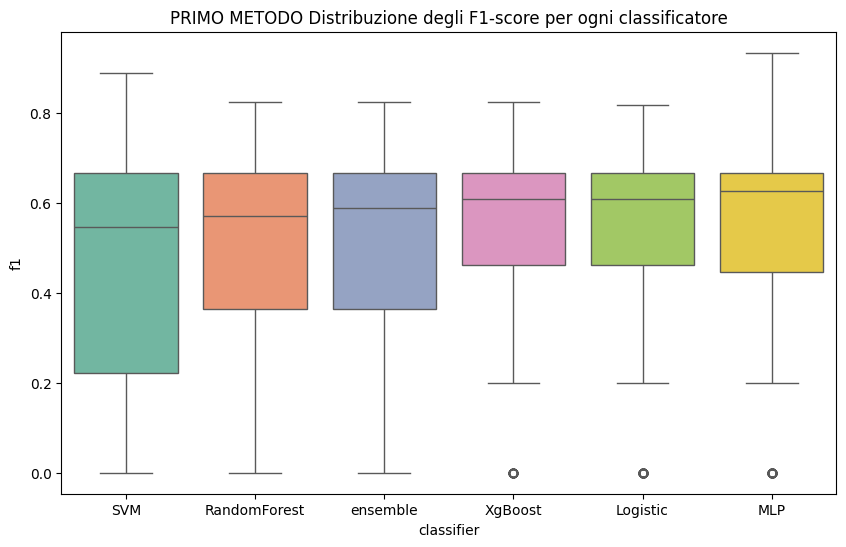

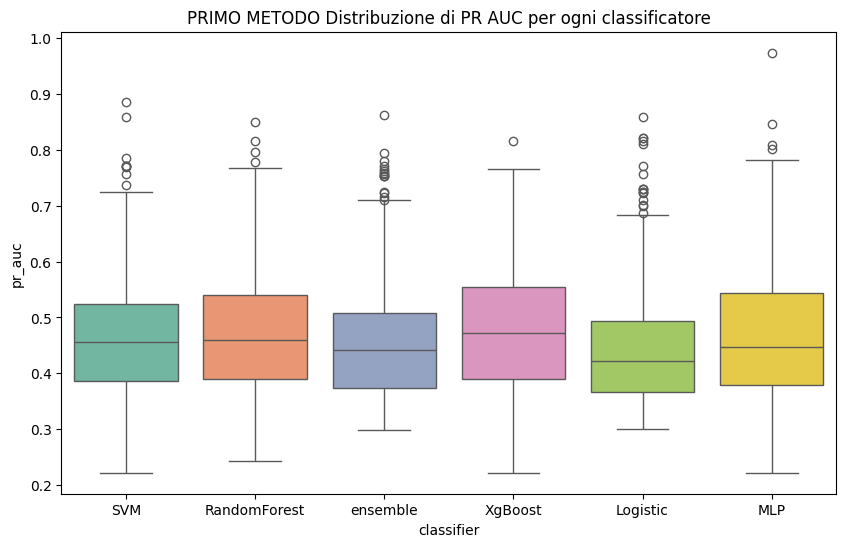

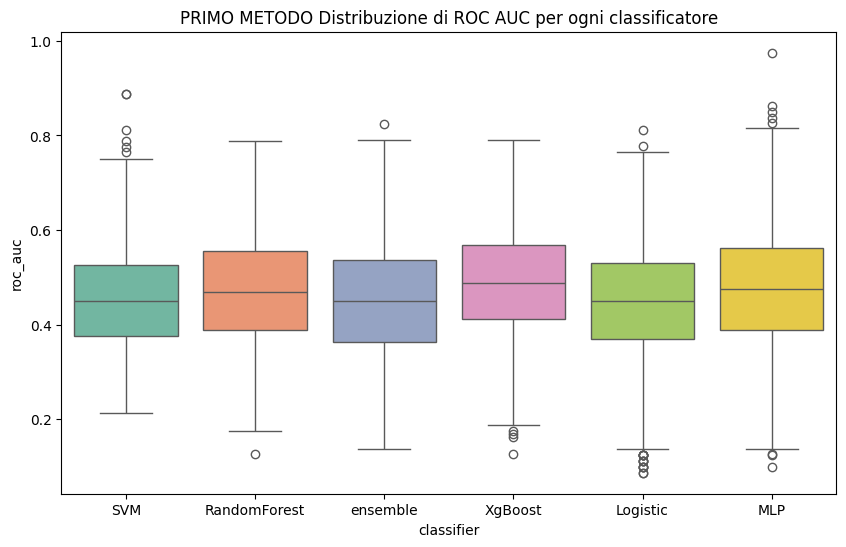

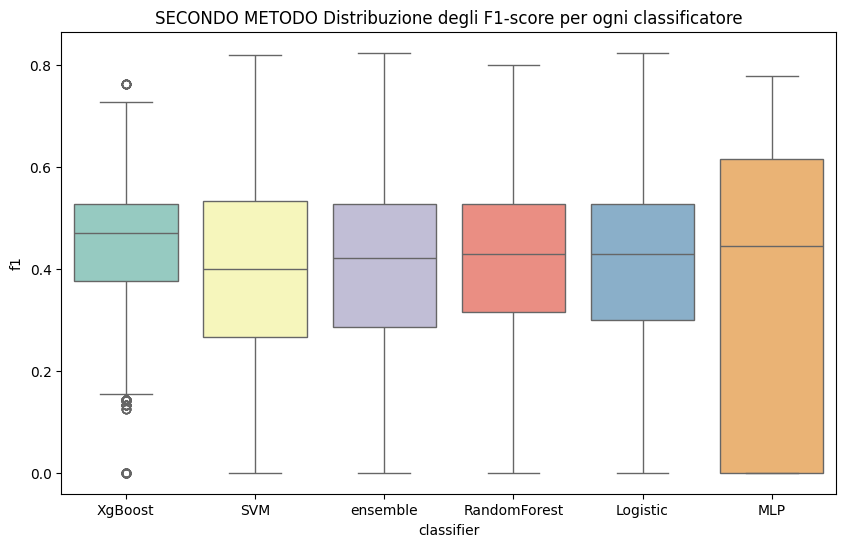

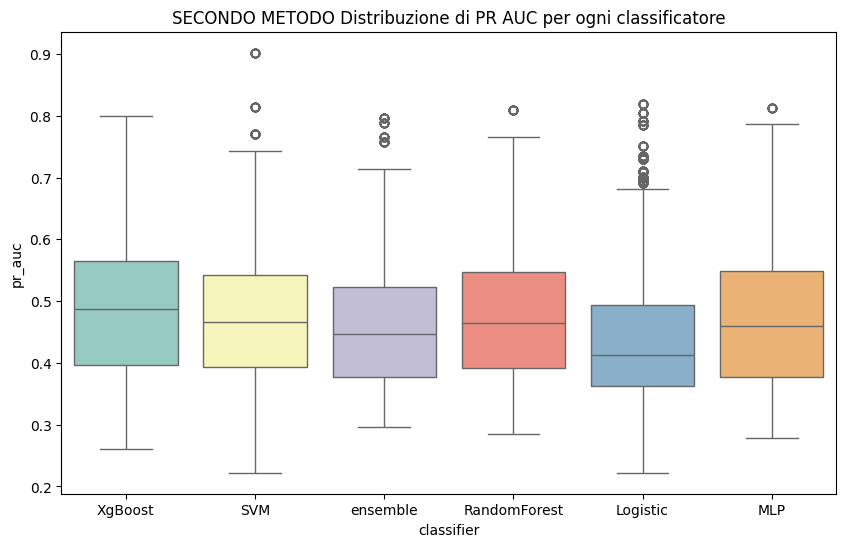

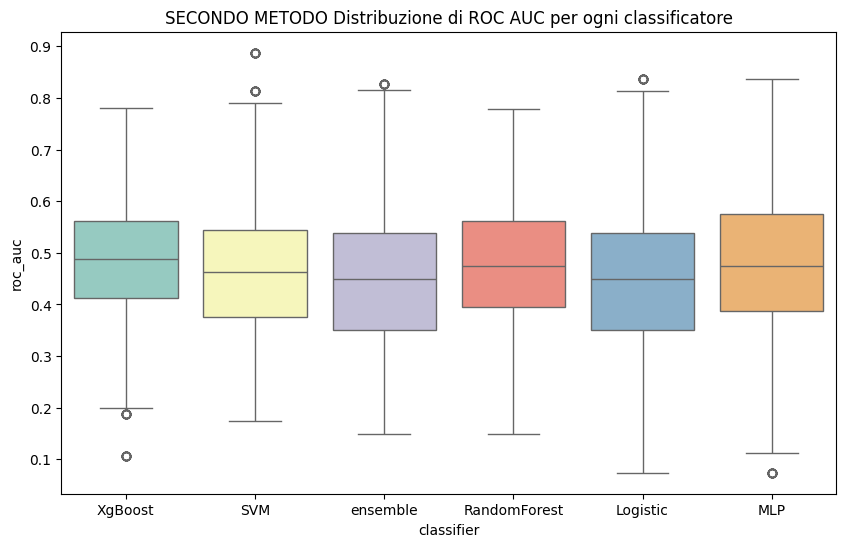

In [230]:

palette_primo_metodo = 'Set2'
palette_secondo_metodo = 'Set3'

results_df = pd.DataFrame(results_val_1)

plt.figure(figsize=(10, 6))
sns.boxplot(x='classifier', y='f1', data=results_df, palette=palette_primo_metodo)
plt.title('PRIMO METODO Distribuzione degli F1-score per ogni classificatore')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='classifier', y='pr_auc', data=results_df, palette=palette_primo_metodo)
plt.title('PRIMO METODO Distribuzione di PR AUC per ogni classificatore')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='classifier', y='roc_auc', data=results_df, palette=palette_primo_metodo)
plt.title('PRIMO METODO Distribuzione di ROC AUC per ogni classificatore')
plt.show()

results_df = pd.DataFrame(results_val_2)

plt.figure(figsize=(10, 6))
sns.boxplot(x='classifier', y='f1', data=results_df, palette=palette_secondo_metodo)
plt.title('SECONDO METODO Distribuzione degli F1-score per ogni classificatore')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='classifier', y='pr_auc', data=results_df, palette=palette_secondo_metodo)
plt.title('SECONDO METODO Distribuzione di PR AUC per ogni classificatore')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='classifier', y='roc_auc', data=results_df, palette=palette_secondo_metodo)
plt.title('SECONDO METODO Distribuzione di ROC AUC per ogni classificatore')
plt.show()
